### Import Necessary Libraries

In [3]:
import numpy as np
import nltk
import sklearn as sk
import pandas as pd
from bs4 import BeautifulSoup
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

### Importing Dataset

In [4]:
imdb_data = pd.read_csv('IMDB Dataset.csv')
imdb_data.shape

(50000, 2)

In [5]:
imdb_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Data Analysis and Sentiment Count

In [6]:
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [7]:
imdb_data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

### Splitting Test and Train Data

In [8]:
train_reviews = imdb_data.review[:40000]
train_sentiments = imdb_data.sentiment[:40000]

test_reviews = imdb_data.review[40000:]
test_sentiments = imdb_data.sentiment[40000:]

print(train_reviews.shape, train_sentiments.shape)
print(test_reviews.shape, test_sentiments.shape)


(40000,) (40000,)
(10000,) (10000,)


### Tokenization of Text

In [9]:
#Tokenization of text
tokenizer = nltk.tokenize.ToktokTokenizer()
#Setting English stopwords
stopword_list = nltk.corpus.stopwords.words('english')

In [10]:
len(stopword_list)

179

### Removal of HTML Strips and Noise in Texts

In [11]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

#Apply function on review column
imdb_data['review'] = imdb_data['review'].apply(denoise_text)
imdb_data['review']

0        One of the other reviewers has mentioned that ...
1        A wonderful little production. The filming tec...
2        I thought this was a wonderful way to spend ti...
3        Basically there's a family where a little boy ...
4        Petter Mattei's "Love in the Time of Money" is...
                               ...                        
49995    I thought this movie did a down right good job...
49996    Bad plot, bad dialogue, bad acting, idiotic di...
49997    I am a Catholic taught in parochial elementary...
49998    I'm going to have to disagree with the previou...
49999    No one expects the Star Trek movies to be high...
Name: review, Length: 50000, dtype: object

### Removal of Special Characters

In [12]:
def remove_special_characters(text, remove_digits = True):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern,'',text)
    return text

imdb_data['review'] = imdb_data['review'].apply(remove_special_characters)
imdb_data['review']

0        One of the other reviewers has mentioned that ...
1        A wonderful little production The filming tech...
2        I thought this was a wonderful way to spend ti...
3        Basically theres a family where a little boy J...
4        Petter Matteis Love in the Time of Money is a ...
                               ...                        
49995    I thought this movie did a down right good job...
49996    Bad plot bad dialogue bad acting idiotic direc...
49997    I am a Catholic taught in parochial elementary...
49998    Im going to have to disagree with the previous...
49999    No one expects the Star Trek movies to be high...
Name: review, Length: 50000, dtype: object

### Text Stemming

In [13]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

imdb_data['review'] = imdb_data['review'].apply(simple_stemmer)
imdb_data['review']

0        one of the other review ha mention that after ...
1        a wonder littl product the film techniqu is ve...
2        i thought thi wa a wonder way to spend time on...
3        basic there a famili where a littl boy jake th...
4        petter mattei love in the time of money is a v...
                               ...                        
49995    i thought thi movi did a down right good job i...
49996    bad plot bad dialogu bad act idiot direct the ...
49997    i am a cathol taught in parochi elementari sch...
49998    im go to have to disagre with the previou comm...
49999    no one expect the star trek movi to be high ar...
Name: review, Length: 50000, dtype: object

### Stopwords Removal

In [14]:
print(len(stopword_list))


def remove_stopwords(text, is_lower_case = False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

imdb_data['review'] = imdb_data['review'].apply(remove_stopwords)
imdb_data['review']
    

179


0        one review ha mention watch 1 oz episod youll ...
1        wonder littl product film techniqu veri unassu...
2        thought thi wa wonder way spend time hot summe...
3        basic famili littl boy jake think zombi hi clo...
4        petter mattei love time money visual stun film...
                               ...                        
49995    thought thi movi right good job wasnt creativ ...
49996    bad plot bad dialogu bad act idiot direct anno...
49997    cathol taught parochi elementari school nun ta...
49998    im go disagre previou comment side maltin thi ...
49999    one expect star trek movi high art fan expect ...
Name: review, Length: 50000, dtype: object

In [15]:
norm_train_reviews = imdb_data.review[:40000]

norm_test_reviews = imdb_data.review[40000:]

### Feature Extraction for Bag of Words

In [16]:
cv = sk.feature_extraction.text.CountVectorizer(min_df = 0, max_df = 1, binary = False, ngram_range = (1,3))
cv_train_reviews = cv.fit_transform(norm_train_reviews)
cv_test_reviews = cv.transform(norm_test_reviews)
print('BOW_cv_train: ', cv_train_reviews.shape)
print('BOW_cv_test: ', cv_test_reviews.shape)

BOW_cv_train:  (40000, 6209089)
BOW_cv_test:  (10000, 6209089)


### Feature Extraction for Term Frequency - Inverse Document Frequency 

In [17]:
tv = sk.feature_extraction.text.TfidfVectorizer(min_df = 0, max_df = 1, use_idf = True, ngram_range = (1,3))
tv_train_reviews = tv.fit_transform(norm_train_reviews)
tv_test_reviews = tv.transform(norm_test_reviews)
print('Tfidf_train:', cv_train_reviews.shape)
print('Tfidf_test:', cv_test_reviews.shape)

Tfidf_train: (40000, 6209089)
Tfidf_test: (10000, 6209089)


### Labeling and Splitting of Sentiment Text

In [18]:
lb = sk.preprocessing.LabelBinarizer()
sentiment_data = lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)

(50000, 1)


In [19]:
train_sentiments=sentiment_data[:40000]
test_sentiments=sentiment_data[40000:]
print(train_sentiments)
print(test_sentiments)

[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


### Logistic Regression Model and Performance on Test Dataset

In [20]:
lr = sk.linear_model.LogisticRegression(penalty = 'l2', max_iter = 500, C = 1, random_state = 42)
lr_bow = lr.fit(cv_train_reviews, train_sentiments)
print(lr_bow)

lr_tfidf = lr.fit(tv_train_reviews, train_sentiments)
print(lr_tfidf)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression(C=1, max_iter=500, random_state=42)


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression(C=1, max_iter=500, random_state=42)


In [21]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


### Accuracy of the Logistic Regression model

In [22]:
#Accuracy score for bag of words
lr_bow_score = sk.metrics.accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score = sk.metrics.accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.7512
lr_tfidf_score : 0.75


### Confusion Matrix

In [23]:
#confusion matrix for bag of words
cm_bow=sk.metrics.confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=sk.metrics.confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3768 1239]
 [1249 3744]]
[[3663 1344]
 [1156 3837]]


### Classification Report

In [24]:
#Classification report for bag of words 
lr_bow_report=sk.metrics.classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=sk.metrics.classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.75      0.75      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

              precision    recall  f1-score   support

    Positive       0.74      0.77      0.75      4993
    Negative       0.76      0.73      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



### Stochastic Gradient Descent and performance on Test Dataset

In [25]:
#training the linear svm
svm=sk.linear_model.SGDClassifier(loss='hinge',max_iter=500,random_state=42)
#fitting the svm for bag of words
svm_bow=svm.fit(cv_train_reviews,train_sentiments)
print(svm_bow)
#fitting the svm for tfidf features
svm_tfidf=svm.fit(tv_train_reviews,train_sentiments)
print(svm_tfidf)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SGDClassifier(max_iter=500, random_state=42)


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SGDClassifier(max_iter=500, random_state=42)


In [26]:
#Predicting the model for bag of words
svm_bow_predict=svm.predict(cv_test_reviews)
print(svm_bow_predict)
#Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(tv_test_reviews)
print(svm_tfidf_predict)

[1 1 0 ... 1 1 1]
[1 1 1 ... 1 1 1]


### Accuracy of the SGD model

In [27]:
#Accuracy score for bag of words
svm_bow_score=sk.metrics.accuracy_score(test_sentiments,svm_bow_predict)
print("svm_bow_score :",svm_bow_score)
#Accuracy score for tfidf features
svm_tfidf_score=sk.metrics.accuracy_score(test_sentiments,svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_score)

svm_bow_score : 0.5829
svm_tfidf_score : 0.5112


### Classification Report

In [28]:
#Classification report for bag of words 
svm_bow_report=sk.metrics.classification_report(test_sentiments,svm_bow_predict,target_names=['Positive','Negative'])
print(svm_bow_report)
#Classification report for tfidf features
svm_tfidf_report=sk.metrics.classification_report(test_sentiments,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.94      0.18      0.30      4993
    Negative       0.55      0.99      0.70      5007

    accuracy                           0.58     10000
   macro avg       0.74      0.58      0.50     10000
weighted avg       0.74      0.58      0.50     10000

              precision    recall  f1-score   support

    Positive       1.00      0.02      0.04      4993
    Negative       0.51      1.00      0.67      5007

    accuracy                           0.51     10000
   macro avg       0.75      0.51      0.36     10000
weighted avg       0.75      0.51      0.36     10000



### Confusion Matrix

In [29]:
#confusion matrix for bag of words
cm_bow=sk.metrics.confusion_matrix(test_sentiments,svm_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=sk.metrics.confusion_matrix(test_sentiments,svm_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[4948   59]
 [4112  881]]
[[5007    0]
 [4888  105]]


### Multinomial Naive Bayes model and performance on Test Dataset

In [30]:
#training the model
from sklearn.naive_bayes import MultinomialNB
mnb=MultinomialNB()
#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_reviews,train_sentiments)
print(mnb_bow)
#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,train_sentiments)
print(mnb_tfidf)

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MultinomialNB()


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MultinomialNB()


In [31]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


### Accuracy of the Multinomial Naive Bayes model

In [32]:
#Accuracy score for bag of words
mnb_bow_score=sk.metrics.accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=sk.metrics.accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.751
mnb_tfidf_score : 0.7509


### Classification Report

In [33]:
#Classification report for bag of words 
mnb_bow_report=sk.metrics.classification_report(test_sentiments,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)
#Classification report for tfidf features
mnb_tfidf_report=sk.metrics.classification_report(test_sentiments,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.74      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



### Confusion Matrix

In [34]:
#confusion matrix for bag of words
cm_bow=sk.metrics.confusion_matrix(test_sentiments,mnb_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=sk.metrics.confusion_matrix(test_sentiments,mnb_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3736 1271]
 [1219 3774]]
[[3729 1278]
 [1213 3780]]


### Word Cloud for Positive Review Words 

<function matplotlib.pyplot.show(close=None, block=None)>

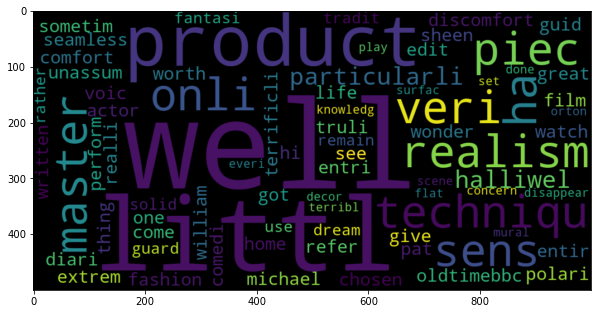

In [35]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=norm_train_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

### Word Cloud for Negative Review Words

<function matplotlib.pyplot.show(close=None, block=None)>

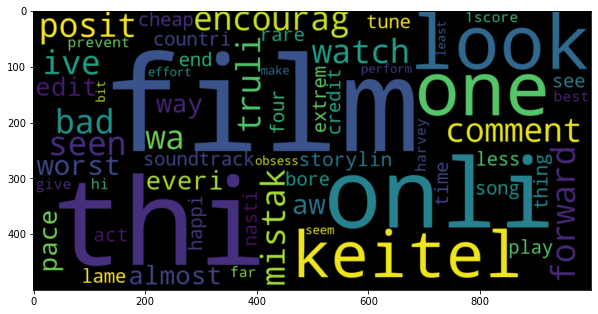

In [36]:
plt.figure(figsize=(10,10))
negative_text=norm_train_reviews[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show
